In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
# prompt: define a pytroch Dataset class that loads images from a folder containing .npy files

import os
import numpy as np
from torch.utils.data import Dataset

class NPYDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.file_list = [f for f in os.listdir(root_dir) if f.endswith('.npy')]

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_path = os.path.join(self.root_dir, self.file_list[idx])
        image = np.load(file_path)
        # You can add any necessary preprocessing here, like converting to tensor, normalizing, etc.
        image = torch.from_numpy(image).float()
        return image

In [3]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU()
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [4]:
# Create the model
model = Autoencoder()

# Assuming you have GPU available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

In [5]:
# Training loop (assuming you have a DataLoader called 'dataloader')
def train(model, dataloader, epochs):
    device = next(model.parameters()).device
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        total_loss_spect = 0
        total_loss_chroma = 0
        total_loss_tempo = 0
        for data in dataloader:
            img = data.permute(0, 3, 1, 2)
            img = img.to(device)

            # Forward pass
            output = model(img)
            loss_spect = criterion(output[:,0,:,:], img[:,0,:,:])
            loss_chroma = criterion(output[:,1:,:,:], img[:,1:,:,:])
            loss_tempo = criterion(output[:,2:,:,:], img[:,2:,:,:])
            loss = 0.1*loss_spect + loss_chroma + loss_tempo

            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_loss_spect += loss_spect.item()
            total_loss_chroma += loss_chroma.item()
            total_loss_tempo += loss_tempo.item()

        avg_loss = total_loss / len(dataloader)
        avg_loss_spect = total_loss_spect / len(dataloader)
        avg_loss_chroma = total_loss_chroma / len(dataloader)
        avg_loss_tempo = total_loss_tempo / len(dataloader)
        print(f'Epoch [{epoch+1}/{epochs}], Total Loss: {avg_loss:.4f}, Loss_spect: {avg_loss_spect:.4f}, Loss_tempo: {avg_loss_tempo:.4f}, Loss_chroma: {avg_loss_chroma:.4f} ')


In [9]:
!unzip -q train.zip

In [11]:
npy_dataset = NPYDataset(root_dir='./000')
dataloader = torch.utils.data.DataLoader(npy_dataset, batch_size=8, shuffle=True)

In [ ]:
train(model, dataloader, epochs=30)

Epoch [1/30], Total Loss: 4.3301, Loss_spect: 40.0722, Loss_tempo: 0.1305, Loss_chroma: 0.1923 
Epoch [2/30], Total Loss: 4.2687, Loss_spect: 39.4835, Loss_tempo: 0.1299, Loss_chroma: 0.1904 
Epoch [3/30], Total Loss: 4.2709, Loss_spect: 39.5259, Loss_tempo: 0.1285, Loss_chroma: 0.1899 
Epoch [4/30], Total Loss: 4.2257, Loss_spect: 39.1826, Loss_tempo: 0.1226, Loss_chroma: 0.1848 
Epoch [5/30], Total Loss: 4.1911, Loss_spect: 38.8483, Loss_tempo: 0.1225, Loss_chroma: 0.1838 
Epoch [6/30], Total Loss: 4.1269, Loss_spect: 38.2691, Loss_tempo: 0.1194, Loss_chroma: 0.1806 
Epoch [7/30], Total Loss: 4.1069, Loss_spect: 38.0951, Loss_tempo: 0.1180, Loss_chroma: 0.1793 
Epoch [8/30], Total Loss: 4.0816, Loss_spect: 37.9191, Loss_tempo: 0.1141, Loss_chroma: 0.1755 
Epoch [9/30], Total Loss: 4.0265, Loss_spect: 37.4018, Loss_tempo: 0.1122, Loss_chroma: 0.1742 
Epoch [10/30], Total Loss: 4.0090, Loss_spect: 37.2450, Loss_tempo: 0.1116, Loss_chroma: 0.1728 
Epoch [11/30], Total Loss: 3.9827, Loss

In [ ]:
torch.save(model.state_dict(), 'autoencoder_model_loss_best.pth')

In [16]:
model = Autoencoder()
model.load_state_dict(torch.load('autoencoder_model_loss_best.pth', weights_only=True))
model = model.to(device)

In [14]:
!unzip -q test.zip -d test

In [17]:
# prompt: perform inference on npy files from a given folder. save the model outputs to the "predictions" folder, and use the same file names

import torch
import os
import numpy as np

model.eval()

# Specify the input folder and output folder
input_folder = 'test'
output_folder = 'predictions'

# Create the output folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Iterate through the NPY files in the input folder
for filename in os.listdir(input_folder):
    if filename.endswith('.npy'):
        file_path = os.path.join(input_folder, filename)
        image = np.load(file_path)

        # Convert to tensor and move to the device
        image = torch.from_numpy(image).float()
        image = image.unsqueeze(0).permute(0, 3, 1, 2)  # Add batch dimension and reshape
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        image = image.to(device)

        # Perform inference
        with torch.no_grad():
            output = model(image)

        # Convert output tensor to numpy array
        output = output.cpu().numpy()

        # Save the output to the predictions folder with the same filename
        output_file_path = os.path.join(output_folder, filename)
        np.save(output_file_path, output[0])

print("Inference complete. Predictions saved to the 'predictions' folder.")

Inference complete. Predictions saved to the 'predictions' folder.


In [ ]:
# !zip -r -q predictions_loss_2.zip predictions_loss_2/

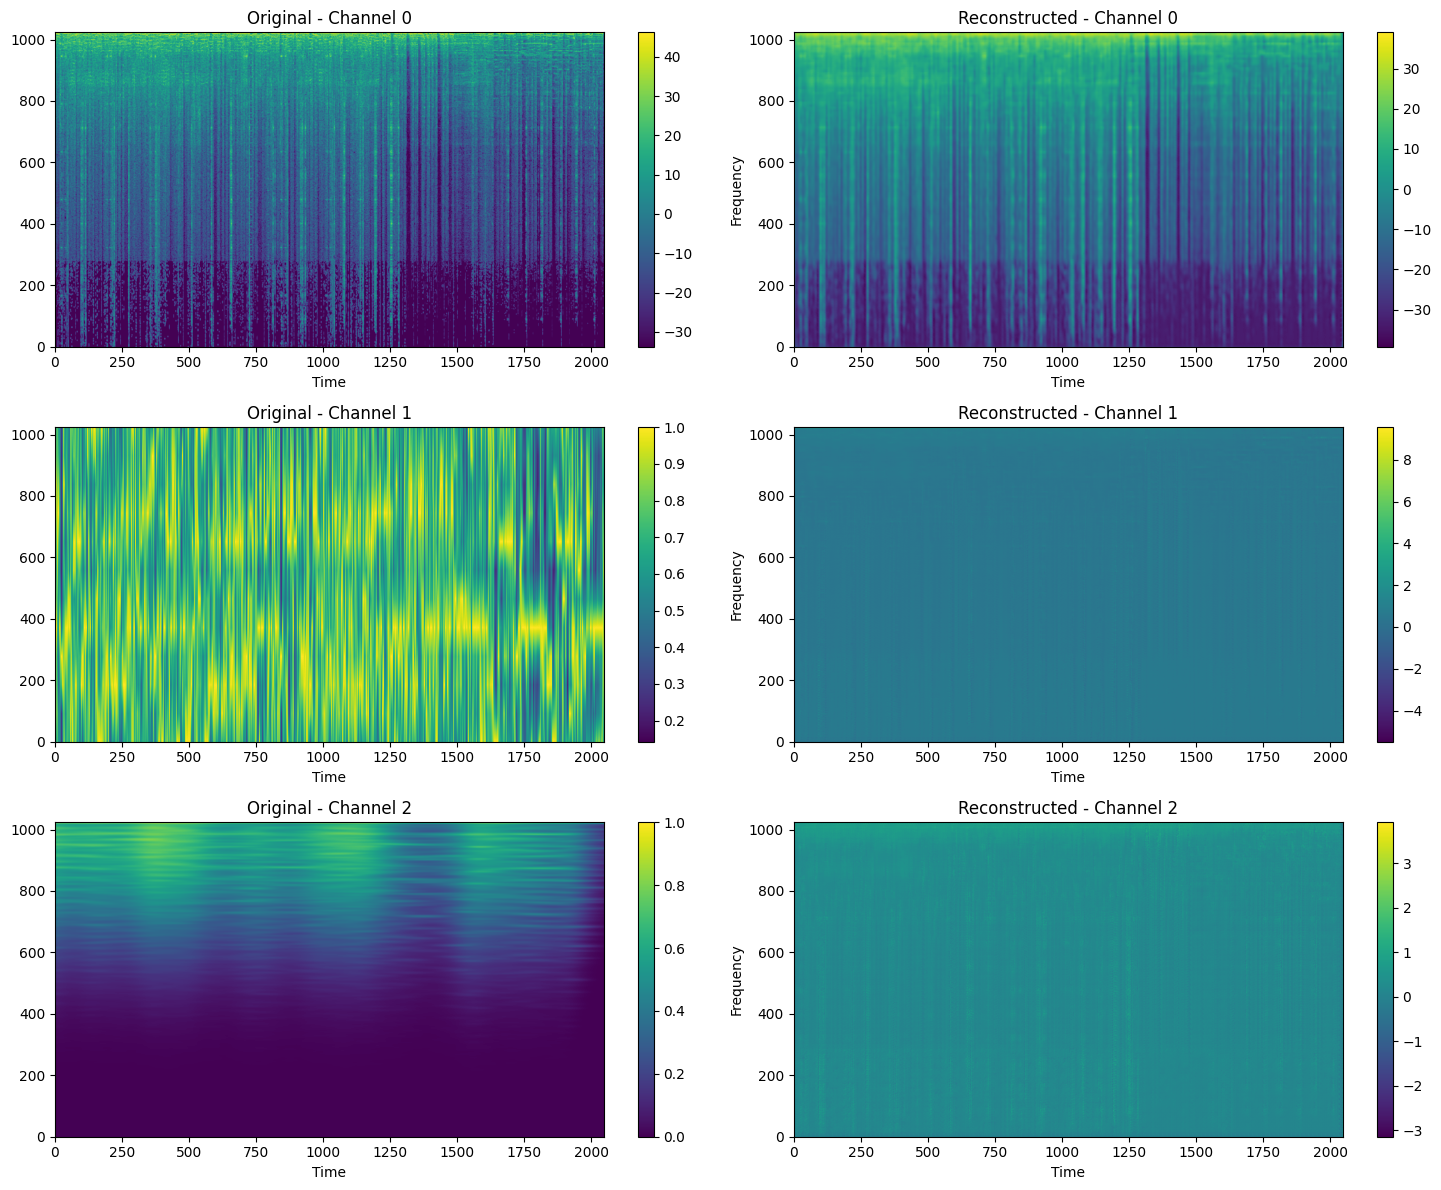

In [18]:
import matplotlib.pyplot as plt

filename = "001073.npy"

image = np.load(f'test/{filename}')
prediction = np.load(f'predictions/{filename}')

plt.figure(figsize=(15, 12))

for i in range(3):
    # Plot the original image for each channel
    plt.subplot(3, 2, 2*i + 1)
    image_1 = image[:,:,i]
    plt.imshow(image_1, aspect='auto', origin='lower')
    plt.colorbar()
    plt.xlabel('Time')
    plt.title(f'Original - Channel {i}')

    # Plot the reconstructed image for each channel
    plt.subplot(3, 2, 2*i + 2)
    image_1 = prediction[i,:,:]
    plt.imshow(image_1, aspect='auto', origin='lower')
    plt.colorbar()
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.title(f'Reconstructed - Channel {i}')

plt.tight_layout()
plt.show()



Load the genre_track_dict of the validation set

In [20]:
import json

genre_dict = json.load(open('genre_track_dict.json'))

Generate new genre_track_dict with only the tracks in the training folder

In [21]:
# prompt: genere_dict is a dictionary of genre keys and list of track ids values. list the npy files in the "000" folder, and count how many tracks there are for each genre. The filenames are in the form "<track_id>.npy"

import os

def count_tracks_per_genre(genre_dict, folder_path):
  """Counts the number of tracks for each genre in a given folder.

  Args:
    genre_dict: A dictionary where keys are genres and values are lists of track IDs.
    folder_path: The path to the folder containing the NPY files.

  Returns:
    A dictionary where keys are genres and values are the number of tracks
    belonging to that genre.
  """

  genre_counts = {genre: 0 for genre in genre_dict}
  new_genre_dict = {}
  for filename in os.listdir(folder_path):
    if filename.endswith('.npy'):
      track_id = filename[:-4]  # Remove the ".npy" extension
      track_id = int(track_id)
      for genre, track_ids in genre_dict.items():
        if track_id in track_ids:
          genre_counts[genre] += 1
          if genre not in new_genre_dict:
            new_genre_dict[genre] = []
          new_genre_dict[genre].append(track_id)
          break  # A track can only belong to one genre
  return genre_counts, new_genre_dict

# Example usage:
folder_path = './000'
genre_counts, new_genre_dict = count_tracks_per_genre(genre_dict, folder_path)

print("Track counts per genre:")
for genre, count in genre_counts.items():
  print(f"{genre}: {count}")

print(f"Total number of tracks: {sum(genre_counts.values())}")

json.dump(new_genre_dict, open('genre_track_dict_000.json', 'w'))


Track counts per genre:
Electronic: 0
Experimental: 7
Folk: 27
Hip-Hop: 5
Instrumental: 0
International: 9
Pop: 4
Rock: 10
Total number of tracks: 62


## Embedder Model

In [22]:
class Embedder(nn.Module):
    def __init__(self):
        super(Embedder, self).__init__()

        self.conv1 = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(512, 256, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1)
        self.activation = nn.LeakyReLU(0.2)
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, x):
        x = self.activation(self.conv1(x))
        x = self.activation(self.conv2(x))
        x = self.activation(self.conv3(x))
        x = self.global_avg_pool(x)
        return x.view(-1, 128)

class EncoderEmbedder(nn.Module):
    def __init__(self, encoder, embedder):
        super(EncoderEmbedder, self).__init__()
        self.encoder = encoder
        self.embedder = embedder # replace with CNN + GRU

        # Freeze the encoder
        for param in self.encoder.parameters():
            param.requires_grad = False

    def forward(self, x):
        encoded = self.encoder(x)
        embedded = self.embedder(encoded)
        return embedded

In [23]:
import pandas as pd

class TripletNPYDataset(Dataset):
    def __init__(self, root_dir, genre_track_dict, small):
        self.root_dir = root_dir
        self.file_list = [f for f in os.listdir(root_dir) if f.endswith('.npy')]
        self.genre_track_dict = genre_track_dict
        self.small = small

    def __len__(self):
        return len(self.file_list)

    def _get_samples(self, anchor_genre):
        positive_tracks = self.genre_track_dict[anchor_genre]
        positive_track = np.random.choice(positive_tracks)

        other_bins = [bin for bin in self.genre_track_dict.keys() if bin != anchor_genre]
        other_bin = np.random.choice(other_bins)
        negative_track = np.random.choice(self.genre_track_dict[other_bin])

        return str(positive_track), str(negative_track)


    def __getitem__(self, idx):
        file_path = os.path.join(self.root_dir, self.file_list[idx])
        anchor = np.load(file_path)

        anchor_genre = self.small.loc[self.small['track_id'] == int(self.file_list[idx][:-4]), 'genre'].values[0]
        positive_track, negative_track = self._get_samples(anchor_genre)

        positive_path = os.path.join(self.root_dir, f"{positive_track.zfill(6)}.npy")
        negative_path = os.path.join(self.root_dir, f"{negative_track.zfill(6)}.npy")

        positive = np.load(positive_path)
        negative = np.load(negative_path)

        # You can add any necessary preprocessing here, like converting to tensor, normalizing, etc.
        anchor = torch.from_numpy(anchor).float()
        positive = torch.from_numpy(positive).float()
        negative = torch.from_numpy(negative).float()
        return anchor, positive, negative

In [24]:
class MyTripletLoss:
    def __init__(self, margin=1.0):
        self.margin = margin

    def __call__(self, anchor, positive, negative):
        distance_positive = torch.linalg.norm(anchor - positive, dim=1)
        distance_negative = torch.linalg.norm(anchor - negative, dim=1)
        loss = torch.relu(distance_positive - distance_negative + self.margin)
        return loss.mean(), distance_positive.mean(), distance_negative.mean()


In [26]:
small = pd.read_csv('small.csv') # small.cvs of the valid set
triplet_dataset = TripletNPYDataset(root_dir='./000', genre_track_dict=new_genre_dict, small=small)
triplet_dataloader = torch.utils.data.DataLoader(triplet_dataset, batch_size=8, shuffle=True)

In [27]:
embedder = Embedder()
encoder_embedder = EncoderEmbedder(model.encoder, embedder)
encoder_embedder = encoder_embedder.to(device)

# Define loss function and optimizer
triplet_loss = MyTripletLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

Test model and triplet loss

In [30]:
anchor, positive, negative = next(iter(triplet_dataloader))
anchor = anchor.permute(0, 3, 1, 2).to(device)
positive = positive.permute(0, 3, 1, 2).to(device)
negative = negative.permute(0, 3, 1, 2).to(device)

anchor_embedding = encoder_embedder(anchor)
positive_embedding = encoder_embedder(positive)
negative_embedding = encoder_embedder(negative)

loss, distance_positive, distance_negative = triplet_loss(anchor_embedding, positive_embedding, negative_embedding)

loss, distance_positive, distance_negative

(tensor(3.6500, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(13.3319, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(15.9442, device='cuda:0', grad_fn=<MeanBackward0>))

In [31]:
def train_triplet(encoder_embedder, triplet_dataloader, epochs):
    device = next(encoder_embedder.parameters()).device
    encoder_embedder.train()
    for epoch in range(epochs):
        total_loss = 0
        total_dist_positive = 0
        total_dist_negative = 0
        for anchor, positive, negative in triplet_dataloader:
            anchor = anchor.permute(0, 3, 1, 2).to(device)
            positive = positive.permute(0, 3, 1, 2).to(device)
            negative = negative.permute(0, 3, 1, 2).to(device)

            anchor_embedding = encoder_embedder(anchor)
            positive_embedding = encoder_embedder(positive)
            negative_embedding = encoder_embedder(negative)

            loss, dist_positive, dist_negative = triplet_loss(anchor_embedding, positive_embedding, negative_embedding)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_dist_positive += dist_positive.item()
            total_dist_negative += dist_negative.item()

        avg_loss = total_loss / len(triplet_dataloader)
        avg_dist_positive = total_dist_positive / len(triplet_dataloader)
        avg_dist_negative = total_dist_negative / len(triplet_dataloader)
        print(f'Epoch [{epoch+1}/{epochs}], Triplet Loss: {avg_loss:.4f}, Avg Dist Positive: {avg_dist_positive:.4f}, Avg Dist Negative: {avg_dist_negative:.4f}')


In [32]:
# Train the encoder_embedder
train_triplet(encoder_embedder, triplet_dataloader, epochs=30)

Epoch [1/30], Triplet Loss: 4.0937, Avg Dist Positive: 13.8514, Avg Dist Negative: 20.9438
Epoch [2/30], Triplet Loss: 4.8034, Avg Dist Positive: 14.1256, Avg Dist Negative: 19.2526
Epoch [3/30], Triplet Loss: 5.1383, Avg Dist Positive: 16.3045, Avg Dist Negative: 21.8581
Epoch [4/30], Triplet Loss: 2.6581, Avg Dist Positive: 13.5130, Avg Dist Negative: 23.9014
Epoch [5/30], Triplet Loss: 4.8310, Avg Dist Positive: 15.8014, Avg Dist Negative: 21.6959
Epoch [6/30], Triplet Loss: 2.4748, Avg Dist Positive: 12.1783, Avg Dist Negative: 22.9920
Epoch [7/30], Triplet Loss: 2.8424, Avg Dist Positive: 14.4091, Avg Dist Negative: 22.4708
Epoch [8/30], Triplet Loss: 4.0588, Avg Dist Positive: 12.3668, Avg Dist Negative: 18.7395
Epoch [9/30], Triplet Loss: 3.8615, Avg Dist Positive: 13.4690, Avg Dist Negative: 21.0281
Epoch [10/30], Triplet Loss: 5.2420, Avg Dist Positive: 17.1230, Avg Dist Negative: 22.6552
Epoch [11/30], Triplet Loss: 3.1915, Avg Dist Positive: 13.6823, Avg Dist Negative: 22.92